<a href="https://colab.research.google.com/github/akhi-uday/KneeBoneSegmentation/blob/main/DualChannelUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import *
from keras.preprocessing.image import ImageDataGenerator	


seed = 4446
random.seed = seed
np.random.seed = seed
tf.seed = seed

! pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_data(path,id_name):
        image_size = 384
        image_path = os.path.join(path, "image",id_name)
        mask_path = os.path.join(path, "mask",id_name).replace(".jpeg","_mask.png")
        
        
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (image_size, image_size),interpolation=cv2.INTER_AREA)
        
        mask = np.zeros((image_size, image_size, 1))
        
        
        _mask_image = cv2.imread(mask_path, -1)
        _mask_image = cv2.resize(_mask_image, (image_size, image_size)) 
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)
            
        
        image = image/255.0
        mask = mask/255.0
        
        return image ,mask

def gen_dataset(path):
  images = next(os.walk(path+"/image"))[2]
  X = []
  y = []
  for img in images:
    i,m = get_data(path,img)
    X.append(i)
    y.append(m)
  return np.array(X),np.array(y)
  

In [ ]:
image_size = 384
path = "drive/MyDrive/data/train"
train_img_path = "drive/MyDrive/data/train/image"
train_msk_path = "drive/MyDrive/data/train/mask"
epochs = 5
batch_size = 8


train_img = next(os.walk(train_img_path))[2]
train_mask = next(os.walk(train_msk_path))[2]
# train_ids

val_data_size = 10

valid_img = next(os.walk("drive/MyDrive/data/val/image"))[2]
valid_mask = next(os.walk("drive/MyDrive/data/val/mask"))[2]
# valid_img

In [ ]:
import numpy as np 
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D,UpSampling2D,BatchNormalization, Dropout,Conv2DTranspose,concatenate,Lambda
from keras.models import Sequential,Model,Input,load_model
from tensorflow.keras.optimizers import Adam

def dcunet():

    kernel_size = (3,3)
    t_kernel_size = (2,2)
    pool = (2,2)
    act = 'relu'
    lastact = 'sigmoid'
    pad = 'same'
    init = 'he_normal'
    learning_rate = 1e-5
    loss_fn = 'binary_crossentropy'


    shape = Input((384,384,3))

    dc1 = Conv2D(8,kernel_size=kernel_size,activation=act,padding=pad,kernel_initializer=init)(shape)
    dc1 = Conv2D(17,kernel_size=kernel_size,activation=act,padding=pad,kernel_initializer=init)(dc1)
    dc1 = Conv2D(26,kernel_size=kernel_size,activation=act,padding=pad,kernel_initializer=init)(dc1)
    rp1 = Conv2D(32,kernel_size=(3,3),activation=act,padding=pad)(dc1)
    rp1 = Conv2D(32,kernel_size=(1,1),activation=act,padding=pad)(rp1)
    rp1 = Conv2D(32,kernel_size=(3,3),activation=act,padding=pad)(rp1)
    rp1 = Conv2D(32,kernel_size=(1,1),activation=act,padding=pad)(rp1)
    rp1 = Conv2D(32,kernel_size=(3,3),activation=act,padding=pad)(rp1)
    rp1 = Conv2D(32,kernel_size=(1,1),activation=act,padding=pad)(rp1)
    rp1 = Conv2D(32,kernel_size=(3,3),activation=act,padding=pad)(rp1)
    rp1 = Conv2D(32,kernel_size=(1,1),activation=act,padding=pad)(rp1)
    pool1 = MaxPooling2D(pool)(dc1)
    drop1 = Dropout(0.5)(pool1)


    dc2 = Conv2D(17,kernel_size=kernel_size,activation=act,padding=pad)(drop1)
    dc2 = Conv2D(35,kernel_size=kernel_size,activation=act,padding=pad)(dc2)
    dc2 = Conv2D(53,kernel_size=kernel_size,activation=act,padding=pad)(dc2)
    rp2 = Conv2D(64,kernel_size=(3,3),activation=act,padding=pad)(dc2)
    rp2 = Conv2D(64,kernel_size=(1,1),activation=act,padding=pad)(rp2)
    rp2 = Conv2D(64,kernel_size=(3,3),activation=act,padding=pad)(rp2)
    rp2 = Conv2D(64,kernel_size=(1,1),activation=act,padding=pad)(rp2)
    rp2 = Conv2D(64,kernel_size=(3,3),activation=act,padding=pad)(rp2)
    rp2 = Conv2D(64,kernel_size=(1,1),activation=act,padding=pad)(rp2)
    pool2 = MaxPooling2D(pool)(dc2)
    drop2 = Dropout(0.5)(pool2)

    dc3 = Conv2D(35,kernel_size=kernel_size,activation=act,padding=pad)(drop2)
    dc3 = Conv2D(17,kernel_size=kernel_size,activation=act,padding=pad)(dc3)
    dc3 = Conv2D(106,kernel_size=kernel_size,activation=act,padding=pad)(dc3)
    rp3 = Conv2D(128,kernel_size=(3,3),activation=act,padding=pad)(dc3)
    rp3 = Conv2D(128,kernel_size=(1,1),activation=act,padding=pad)(rp3)
    rp3 = Conv2D(128,kernel_size=(3,3),activation=act,padding=pad)(rp3)
    rp3 = Conv2D(128,kernel_size=(1,1),activation=act,padding=pad)(rp3)
    pool3 = MaxPooling2D(pool)(dc3)
    drop3 = Dropout(0.5)(pool3)

    dc4 = Conv2D(71,kernel_size=kernel_size,activation=act,padding=pad)(drop3)
    dc4 = Conv2D(142,kernel_size=kernel_size,activation=act,padding=pad)(dc4)
    dc4 = Conv2D(213,kernel_size=kernel_size,activation=act,padding=pad)(dc4)
    rp4 = Conv2D(256,kernel_size=(3,3),activation=act,padding=pad)(dc4)
    rp4 = Conv2D(256,kernel_size=(1,1),activation=act,padding=pad)(rp4)
    pool4 = MaxPooling2D(pool)(dc4)
    drop4 = Dropout(0.5)(pool4)

    dc5 = Conv2D(142,kernel_size=kernel_size,activation=act,padding=pad)(drop4)
    dc5 = Conv2D(284,kernel_size=kernel_size,activation=act,padding=pad)(dc5)
    dc5 = Conv2D(427,kernel_size=kernel_size,activation=act,padding=pad)(dc5)


    dc6 = Conv2DTranspose(256,kernel_size=t_kernel_size,strides=(2, 2),activation=act,padding=pad)(dc5)
    merge6= concatenate([rp4,dc6], axis = 3)
    merge6= Dropout(0.5)(merge6)
    dc6 = Conv2D(213,kernel_size=kernel_size,activation=act,padding=pad)(merge6)
    dc6 = Conv2D(142,kernel_size=kernel_size,activation=act,padding=pad)(dc6)
    dc6 = Conv2D(71,kernel_size=kernel_size,activation=act,padding=pad)(dc6)

    dc7 = Conv2DTranspose(128,kernel_size=kernel_size,strides=(2, 2),activation=act,padding=pad)(dc6)
    merge7= concatenate([rp3,dc7], axis = 3)
    merge7= Dropout(0.5)(merge7)
    dc7 = Conv2D(106,kernel_size=kernel_size,activation=act,padding=pad)(merge7)
    dc7 = Conv2D(71,kernel_size=kernel_size,activation=act,padding=pad)(dc7)
    dc7 = Conv2D(35,kernel_size=kernel_size,activation=act,padding=pad)(dc7)

    dc8 = Conv2DTranspose(64,kernel_size=kernel_size,strides=(2, 2),activation=act,padding=pad)(dc7)
    merge8= concatenate([rp2,dc8], axis = 3)
    merge8= Dropout(0.5)(merge8)
    dc8 = Conv2D(53,kernel_size=kernel_size,activation=act,padding=pad)(merge8)
    dc8 = Conv2D(35,kernel_size=kernel_size,activation=act,padding=pad)(dc8)
    dc8 = Conv2D(17,kernel_size=kernel_size,activation=act,padding=pad)(dc8)

    dc9 = Conv2DTranspose(32,kernel_size=kernel_size,strides=(2, 2),activation=act,padding=pad)(dc8)
    merge = concatenate([rp1,dc9], axis = 3)
    merge = Dropout(0.5)(merge)
    dc9 = Conv2D(26,kernel_size=kernel_size,activation=act,padding=pad)(merge)
    dc9 = Conv2D(17,kernel_size=kernel_size,activation=act,padding=pad)(dc9)
    dc9 = Conv2D(8,kernel_size=kernel_size,activation=act,padding=pad)(dc9)
    output = Conv2D(1,kernel_size=(1,1),activation=lastact,padding=pad)(dc9)

    model = Model(inputs=shape,outputs=output)

    model.compile(optimizer=Adam(lr=learning_rate),loss=loss_fn,metrics=['accuracy'])

    return model




In [ ]:
model = dcunet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
x_train,y_train = gen_dataset("drive/MyDrive/data/train")
x_val,y_val = gen_dataset("drive/MyDrive/data/val")
print(len(x_train))



history = model.fit(x_train,y_train, batch_size=8, epochs=25)

47
Epoch 1/25
6/6 [==============================] - 4s 688ms/step - loss: 0.3990 - acc: 0.8236
Epoch 2/25
6/6 [==============================] - 4s 682ms/step - loss: 0.4090 - acc: 0.8161
Epoch 3/25
6/6 [==============================] - 4s 685ms/step - loss: 0.3908 - acc: 0.8275
Epoch 4/25
6/6 [==============================] - 4s 692ms/step - loss: 0.3890 - acc: 0.8275
Epoch 5/25
6/6 [==============================] - 4s 694ms/step - loss: 0.3997 - acc: 0.8207
Epoch 6/25
6/6 [==============================] - 4s 680ms/step - loss: 0.3951 - acc: 0.8306
Epoch 7/25
6/6 [==============================] - 4s 671ms/step - loss: 0.3934 - acc: 0.8311
Epoch 8/25
6/6 [==============================] - 4s 669ms/step - loss: 0.3910 - acc: 0.8228
Epoch 9/25
6/6 [==============================] - 4s 660ms/step - loss: 0.3955 - acc: 0.8192
Epoch 10/25
6/6 [==============================] - 4s 658ms/step - loss: 0.3856 - acc: 0.8312
Epoch 11/25
6/6 [==============================] - 4s 653ms/step -

In [ ]:
dice=0
def get_test_data(path,name):
  # print(path)
  image = cv2.imread(path+"image/"+name, 1)
  image = cv2.resize(image, (384, 384),interpolation=cv2.INTER_AREA)
  image = image/255.0
  # image = np.asarray(image)
  # 
  mask = np.zeros((384, 384, 1))

  _mask_image = cv2.imread(path+"mask/"+name.replace(".jpeg","_mask.png"), -1)
  
  _mask_image = cv2.resize(_mask_image, (384, 384)) 
  _mask_image = np.expand_dims(_mask_image, axis=-1)
  mask = np.maximum(mask, _mask_image)
  mask=mask/255.0
  return image,mask
  

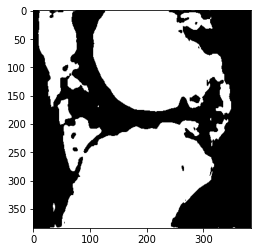

In [ ]:
%matplotlib inline
dice=0
from PIL import Image
c=12
pixel_acc=0
for img in train_img:
  image,mask = get_test_data("drive/MyDrive/data/train/",img)
  result = model.predict(np.array([image]))
  result = result > 0.33
  pixel_acc += (result==mask).sum()
  pixel_acc/=(384*384)

  dice += (2 *(result*mask).sum())/((result+mask).sum() + 1e-8)
  # if not c:
  plt.imshow(np.reshape(result[0]*255, (384, 384)), cmap="gray")
  # c+=1

In [ ]:
print(f"DICE SCORE: {dice/len(train_img)}")

In [ ]:
print(f"PIXEL ERROR: {pixel_acc/c}")